In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms.v2 as transforms 
import torch.optim as optim
import wandb

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(42)
np.random.seed(42)

wandb.login()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
config = dict(
    epochs=10,
    batch_size=32,
    learning_rate=0.001,
    dataset="WildlifeClassification",
    num_classes=10
)

run = wandb.init(project="wildlife-classification", config=config)

Problem at: d:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass1 - Visual Recognition with Deep Learning\.venv\Lib\site-packages\wandb\sdk\wandb_init.py 854 getcaller


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

# Data Loading and Visualization

In [2]:
class WildlifeDataset(Dataset):
    def __init__(self, dir, transform=None):
        super().__init__()
        if transform is None:
            self.transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
        else:
            self.transform = transform
        self.data = datasets.ImageFolder(dir, transform=self.transform)


    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> tuple:
        x, y = self.data[idx]
        if (y > 6):
            y -= 1
        elif (y == 6):
            y = 9
        return x, y

## Datasets and Dataloaders

In [ ]:
dataset = WildlifeDataset('data/Cropped_final')

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.2)
val_size = int(len(dataset)  - train_size - test_size)

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

/home/afterchange/miniconda3/envs/cv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Distribution of classes across train, validation and test sets

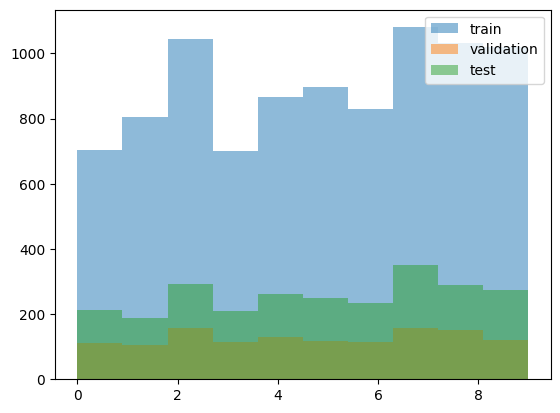

In [ ]:

# Show distribution of classes across train, validation and test sets
train_labels = [label for _, label in train_data]
val_labels = [label for _, label in val_data]
test_labels = [label for _, label in test_data]

plt.hist(train_labels, bins=10, alpha=0.5, label='train')
plt.hist(val_labels, bins=10, alpha=0.5, label='validation')
plt.hist(test_labels, bins=10, alpha=0.5, label='test')

plt.legend(loc='upper right')
plt.show()

# Training CNN from scratch

## CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self,num_classes:int) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,padding=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128*16*16, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.max_pool2(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.max_pool3(out)

        out = out.view(-1, 128*16*16)
        out = self.fc1(out)

        return out


## Defining the CNN model, loss function and optimizer

In [ ]:
model = CNN(num_classes=10)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

## Training the CNN model

In [ ]:
for _ in range(config['epochs']):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for (images, labels) in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
    
    training_accuracy = 100 * correct_train / total_train
    training_loss = running_loss / len(train_loader)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (images, labels) in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels.data).sum().item()

    validation_accuracy = 100 * correct_val / total_val
    validation_loss = running_loss / len(val_loader)

    wandb.log({"Training Loss": training_loss, "Training Accuracy": training_accuracy, "Validation Loss": validation_loss, "Validation Accuracy": validation_accuracy})

## Saving the trained model

In [ ]:
torch.save(model.state_dict(), "wildlife_model.pth")

## Training and validation loss plots and comment whether the model is overfitting or not.

The model is overfitting as the training accuracy is much higher than the validation accuracy.

## Model Evaluation 

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

# Test the model
model.eval()
correct_test = 0
total_test = 0

# log the f1 score
y_true = []
y_pred = []


with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels.data).sum().item()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()


test_accuracy = 100 * correct_test / total_test
wandb.log({"Test Accuracy": test_accuracy})


f1 = f1_score(y_true, y_pred, average='weighted')
wandb.log({"f1_score": f1})

# log the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                y_true=y_true, preds=y_pred,
                                class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])})

# Fine Tunining a Pretrained Model

## Training ResNet18 model

In [ ]:
from torchvision.models import resnet18
import torchvision.models.resnet

# Load the ResNet18 model
model_resnet = resnet18(weights=torchvision.models.resnet.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the model
for param in model_resnet.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes in your dataset
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, config['num_classes'])

model_resnet.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=config['learning_rate'])

# Train the model
for epoch in range(config['epochs']):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = 100 * running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train


    # validate the model
    model_resnet.eval()
    running_loss = 0.0
    correct_eval = 0
    total_eval = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_eval += labels.size(0)
            correct_eval += (predicted == labels).sum().item()

    val_loss = 100 * running_loss / len(val_loader)
    val_accuracy = 100 * correct_eval / total_eval
    
    
    wandb.log({"Training Loss Resnet18": train_loss, "Training Accuracy Resnet18": train_accuracy, "Validation Loss Resnet18": val_loss, "Validation Accuracy Resnet18": val_accuracy})

Training Accuracy Resnet18,▁▅▆▇▇▇████
Training Loss Resnet18,█▄▃▂▂▂▁▁▁▁
Validation Accuracy Resnet18,▁▄▇▇▆▆███▇
Validation Loss Resnet18,█▅▂▂▁▁▂▁▂▂
Training Accuracy Resnet18,85.20664
Training Loss Resnet18,43.6999
Validation Accuracy Resnet18,81.37178
Validation Loss Resnet18,58.02165


## Saving the trained model

In [ ]:
torch.save(model_resnet.state_dict(), "wildlife_model_resnet18.pth")

## Testing the pretrained model

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

model_resnet.eval()

correct_test = 0
total_test = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()


test_accuracy = 100 * correct_test / total_test
wandb.log({"Test Accuracy Resnet18": test_accuracy})

f1 = f1_score(y_true, y_pred, average='weighted')
wandb.log({"f1_score Resnet18": f1})

conf_matrix = confusion_matrix(y_true, y_pred)
wandb.log({"confusion_matrix Resnet18": wandb.plot.confusion_matrix(probs=None,
                                y_true=y_true, preds=y_pred,
                                class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])})


In [ ]:
wandb.finish()

Test Accuracy Resnet18,▁
f1_score Resnet18,▁
Test Accuracy Resnet18,79.49318
f1_score Resnet18,0.7951


## Extracting feature vectors and plotting the distribution of feature vectors

In [ ]:
# Extracting the features from the model
from sklearn.manifold import TSNE

features = []
labels = []



model_resnet.eval()

def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            labels.extend(label.numpy())
            output = model_resnet(images)
            features.extend(output.cpu().numpy())
    return features, labels

train_features, train_labels = extract_features(model_resnet, train_loader)


/tmp/ipykernel_1522279/3295156710.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987289929/work/torch/csrc/utils/tensor_new.cpp:275.)
  train_features = torch.tensor(train_features)


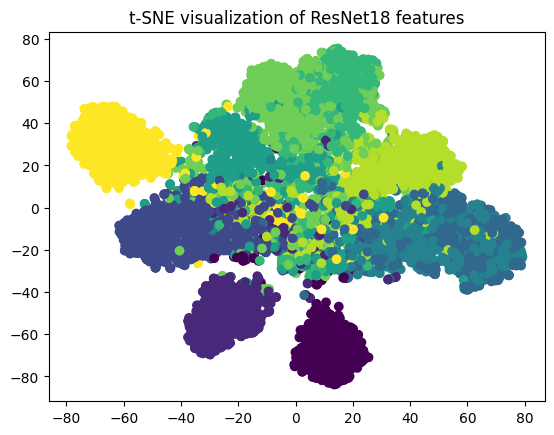

In [ ]:
train_features = torch.tensor(train_features)
train_labels = torch.tensor(train_labels)

tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_features)

plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE visualization of ResNet18 features')
plt.show()

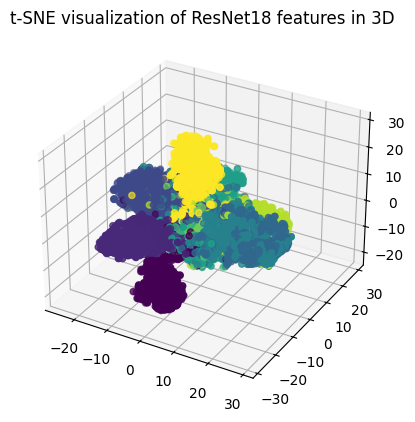

In [ ]:
# visualize the features of the model using t-SNE in 3D
tsne_3d = TSNE(n_components=3, random_state=42)

train_tsne_3d = tsne_3d.fit_transform(train_features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_tsne_3d[:, 0], train_tsne_3d[:, 1], train_tsne_3d[:, 2], c=train_labels, cmap='viridis')
plt.title('t-SNE visualization of ResNet18 features in 3D')
plt.show()

# Data Augmentation

## Performing data augmentation

In [ ]:
# Define the data augmentation transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


augmented_dataset = WildlifeDataset('data/Cropped_final', transform=transform)
normal_dataset = WildlifeDataset('data/Cropped_final')

# sample 20% from the augmented dataset and add it to the normal dataset
augmented_data_size = int(len(augmented_dataset) * 0.1)
augmented_data, _ = torch.utils.data.random_split(augmented_dataset, [augmented_data_size, len(augmented_dataset) - augmented_data_size])

combined_dataset = torch.utils.data.ConcatDataset([normal_dataset, augmented_data])

/home/afterchange/miniconda3/envs/cv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


##  Training CNN with Data Augmentation

In [ ]:
new_train_data_size = int(len(combined_dataset) * 0.7)
new_test_data_size = int(len(combined_dataset) * 0.2)
new_val_data_size = len(combined_dataset) - new_train_data_size - new_test_data_size

train_data_augmented, val_data_augmented, test_data_augmented = torch.utils.data.random_split(combined_dataset, [new_train_data_size, new_val_data_size, new_test_data_size])

train_loader_augmented = DataLoader(train_data_augmented, batch_size=config['batch_size'], shuffle=True)
val_loader_augmented = DataLoader(val_data_augmented, batch_size=config['batch_size'], shuffle=True)
test_loader_augmented = DataLoader(test_data_augmented, batch_size=config['batch_size'], shuffle=True)

In [ ]:
model_augmented = CNN(num_classes=config['num_classes'])
model_augmented.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_augmented.parameters(), lr=config['learning_rate'])

In [ ]:
for _ in range(config['epochs']):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for (images, labels) in train_loader_augmented:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_augmented(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
    
    training_accuracy = 100 * correct_train / total_train
    training_loss = running_loss / len(train_loader_augmented)

    model_augmented.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (images, labels) in val_loader_augmented:
            images, labels = images.to(device), labels.to(device)
            output = model_augmented(images)
            loss = criterion(output, labels)

            running_loss += loss.item() 
            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels.data).sum().item()

    validation_accuracy = 100 * correct_val / total_val
    validation_loss = running_loss / len(val_loader_augmented)

    wandb.log({"Training Loss Augmented": training_loss, "Training Accuracy Augmented": training_accuracy, "Validation Loss Augmented": validation_loss, "Validation Accuracy Augmented": validation_accuracy})

In [ ]:
wandb.finish()

Training Accuracy Augmented,▁▁▁▃▄▆▇▆▅█
Training Loss Augmented,██▆▆▅▃▂▂▂▁
Validation Accuracy Augmented,▁▄▃▄▅▇▄█▃▆
Validation Loss Augmented,█▄▇▄▅▁▇▁▄▂
Training Accuracy Augmented,72.4741
Training Loss Augmented,0.79896
Validation Accuracy Augmented,68.58924
Validation Loss Augmented,0.93238


## Testing the CNN model with data augmentation

In [ ]:
model_augmented.eval()

correct_test = 0
total_test = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader_augmented:
        images, labels = images.to(device), labels.to(device)
        outputs = model_augmented(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()


test_accuracy = 100 * correct_test / total_test
wandb.log({"Test Accuracy Augmented": test_accuracy})

f1 = f1_score(y_true, y_pred, average='weighted')
wandb.log({"f1_score Augmented": f1})

conf_matrix = confusion_matrix(y_true, y_pred)

wandb.log({"confusion_matrix Augmented": wandb.plot.confusion_matrix(probs=None,
                                y_true=y_true, preds=y_pred,
                                class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])})

wandb.finish()

Test Accuracy Augmented,▁
f1_score Augmented,▁
Test Accuracy Augmented,66.12086
f1_score Augmented,0.6618


# Comparing the performance of all the CNN models

Resnet18 model has the best performance among all the models, followed by the CNN model with data augmentation and the CNN model trained from scratch.